In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241120)
np.random.seed(20241120)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [13]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True)

df.columns=[ # 重命名列名
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

var_dict={
    "主蒸汽流量计算值": "t/h",
    "烟气含氧量（CEMS）": "mg/Nm3",
    "NO浓度": "mg/Nm3",
    "NO2浓度": "mg/Nm3",
    "NOX浓度": "mg/Nm3",
    "烟气湿度（CEMS）": "%",
    "烟气压力（CEMS）": "Pa",
    "烟气温度（CEMS）": "℃",
    "一氧化碳": "mg/Nm3",
    "锅炉天然气进气流量": "m3/h",
    "锅炉天然气进气温度": "℃",
    "锅炉天然气进气压力": "kPa",
    '鼓风机出口温度': "℃",
    "鼓风机出口压力": "kPa",
    "鼓风机变频器输出反馈": "Hz",
    "鼓风机变频器电流反馈": "A",
    "冷凝器出口烟气调节阀反馈": "%",
    "炉膛出口烟气压力": "Pa",
    "SWY大气压": "kPa",
    "SWY天气温度": "℃",
    "SWY空气湿度": "%",
    'SWY湿球温度': "℃",
    '主蒸汽温度(蒸汽集箱出口温度）': "℃",
    "主蒸汽压力(蒸汽集箱出口压力）": "MPa",
    "分汽缸温度": "℃",
    "分汽缸压力": "MPa",
    '分汽缸出口至DN400蒸汽温度': "℃",
    '过热器集箱出口蒸汽温度': "℃",
    "冷凝器出口烟气流量": "Nm3/h",
    "冷凝器出口烟气温度": "℃",
}


var_names=list(var_dict.keys())
var_units=list(var_dict.values())

data_np=df[var_names].to_numpy(dtype=float)

DATA=[ # 通过不同切片增加数据量
    data_np,
    data_np[0:200,:],
    data_np[200:400,:],
    data_np[400:600,:],
    data_np[600:800,:],
    data_np[800:1000,:],
    data_np[1000:,:],
    ]

In [14]:
from gas_data_prediction.data_preprocessing import time_series_standardization, time_series_split, train_test_split

input_len=5
output_len=1
input_channels=len(var_names)
output_channels=len(var_names)

DATA, var_mean , var_std_dev = time_series_standardization(data=DATA, mode="multiple") # list of numpy arrays of shape (n_timesteps, n_vars)
X, Y, X_grouped, Y_grouped = time_series_split(data=DATA,input_len=input_len, output_len=output_len, mode="multiple")
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


(train_indices, test_indices),\
    (X_train, Y_train, X_train_grouped, Y_train_grouped), \
    (X_test, Y_test, X_test_grouped, Y_test_grouped) \
        = train_test_split(X_grouped, Y_grouped, train_ratio=0.8, test_ratio=0.2)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("\n")
print("len(X_train_grouped):", len(X_train_grouped))
print("len(Y_train_grouped):", len(Y_train_grouped))
print("X_train_grouped[0] shape:", X_train_grouped[0].shape)
print("Y_train_grouped[0] shape:", Y_train_grouped[0].shape)
print("\n")
print("len(X_test_grouped):", len(X_test_grouped))
print("len(Y_test_grouped):", len(Y_test_grouped))
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("X_test_grouped[0] shape:", X_test_grouped[0].shape)
print("Y_test_grouped[0] shape:", Y_test_grouped[0].shape)

train_indices: [4, 1, 5, 6, 0]
test_indices: [2, 3]
num_train: 5
num_test: 2
X_train shape: (1823, 5, 30)
Y_train shape: (1823, 1, 30)


len(X_train_grouped): 5
len(Y_train_grouped): 5
X_train_grouped[0] shape: (195, 5, 30)
Y_train_grouped[0] shape: (195, 1, 30)


len(X_test_grouped): 2
len(Y_test_grouped): 2
X_test shape: (390, 5, 30)
Y_test shape: (390, 1, 30)
X_test_grouped[0] shape: (195, 5, 30)
Y_test_grouped[0] shape: (195, 1, 30)


In [15]:
from models.LR import LinearRegression, Ridge, Lasso, ElasticNet
from models.SVR import SVR, LinearSVR, NuSVR

shared_params = {
    'input_len': input_len,
    'output_len': output_len,
    'input_channels': input_channels,
    'output_channels': output_channels,
}
model_0 = LinearRegression(**shared_params)
model_1 = Ridge(**shared_params,alpha=1.0)
model_2 = Lasso(**shared_params,alpha=0.1)
model_3 = ElasticNet(**shared_params,alpha=0.01,l1_ratio=0.05)
model_4 = SVR(**shared_params,C=1.0,epsilon=0.1)
model_5 = LinearSVR(**shared_params,C=1.0)
model_6 = NuSVR(**shared_params,C=1.0,nu=0.5)

model=model_4 # change this to try different models
model.fit(X_train,Y_train)


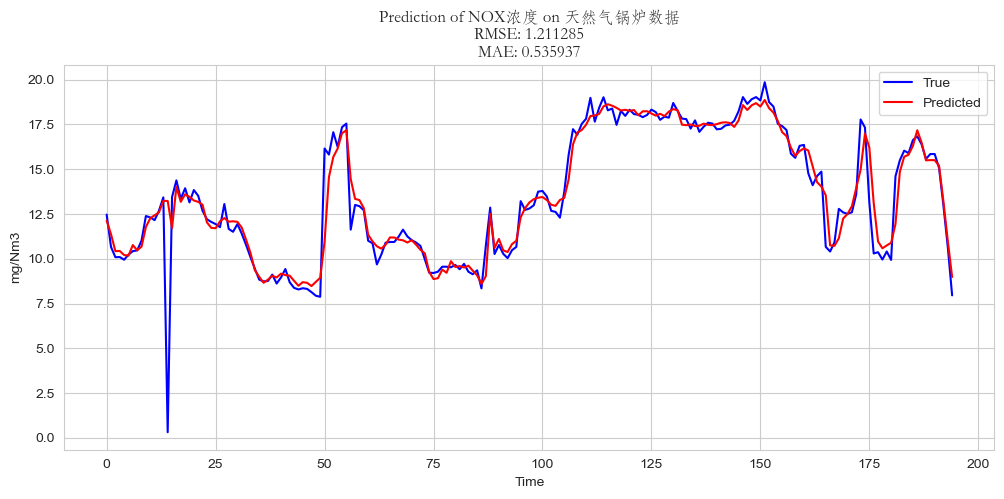

In [16]:
# Visualize on a particular variable and particular file
from gas_data_prediction.utils import visualize_var, get_pred_true_pairs

var_idx=4
data_idx=0

#Y_pred, Y_true=get_pred_true_pairs(model,X_grouped[data_idx],Y_grouped[data_idx])

Y_pred, Y_true=get_pred_true_pairs(model,X_test_grouped[data_idx],Y_test_grouped[data_idx])
#Y_pred, Y_true=get_pred_true_pairs(model,X_grouped[0],Y_grouped[0])


shared_params={
    'Y_pred': Y_pred,
    'Y_true': Y_true,
    'var_idx': var_idx,
    'var_names': var_names,
    'var_units': var_units,
    'data_name': "天然气锅炉数据",
    'var_mean': var_mean,
    'var_std_dev': var_std_dev,
}


visualize_var(**shared_params, plot_residual=0, rescale=1)

In [17]:
var_prediction_info={}
for var_idx, (var_name, var_unit) in enumerate(var_dict.items()):
    Y_pred, Y_true=get_pred_true_pairs(model,X_test_grouped[data_idx],Y_test_grouped[data_idx])
    y_true=Y_true[:,var_idx] # shape: (n_samples,)
    y_pred=Y_pred[:,var_idx] # shape: (n_samples,)
    y_mean=var_mean[var_idx] # float
    y_std_dev=var_std_dev[var_idx] # float

    RMSE=np.sqrt(((y_true-y_pred)**2).mean())
    MAE=np.abs(y_true-y_pred).mean()
    RMSE_rescaled=RMSE*var_std_dev[var_idx]
    MAE_rescaled=MAE*var_std_dev[var_idx]
    var_prediction_info[var_name]=[var_unit, RMSE,RMSE_rescaled,MAE,MAE_rescaled]

df=pd.DataFrame(var_prediction_info,index=['unit', 'RMSE','RMSE_rescaled','MAE','MAE_rescaled']).T
df

,unit,RMSE,RMSE_rescaled,MAE,MAE_rescaled
主蒸汽流量计算值,t/h,0.107019,0.567272,0.083279,0.441435
烟气含氧量（CEMS）,mg/Nm3,0.397816,0.444347,0.171953,0.192066
NO浓度,mg/Nm3,0.389886,1.116163,0.151826,0.434647
NO2浓度,mg/Nm3,0.29147,0.515817,0.15201,0.269014
NOX浓度,mg/Nm3,0.357744,1.211285,0.158285,0.535937
烟气湿度（CEMS）,%,0.27176,0.221303,0.170871,0.139146
烟气压力（CEMS）,Pa,0.464541,3.240184,0.29328,2.045631
烟气温度（CEMS）,℃,0.124624,0.34287,0.097996,0.269609
一氧化碳,mg/Nm3,1.014122,14.172861,0.168711,2.35782
锅炉天然气进气流量,m3/h,0.115657,40.12052,0.086765,30.098015
